<a href="https://colab.research.google.com/github/ahmchua/dl-proj2/blob/master/dl_hw2_srcnn_(l2_not_mse).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip drive/My\ Drive/Colab\ Notebooks/Deep\ Learning/Proj\ 2/val2017.zip

Archive:  drive/My Drive/Colab Notebooks/Deep Learning/Proj 2/val2017.zip
   creating: val2017/
  inflating: val2017/000000182611.jpg  
  inflating: val2017/000000335177.jpg  
  inflating: val2017/000000278705.jpg  
  inflating: val2017/000000463618.jpg  
  inflating: val2017/000000568981.jpg  
  inflating: val2017/000000092416.jpg  
  inflating: val2017/000000173830.jpg  
  inflating: val2017/000000476215.jpg  
  inflating: val2017/000000479126.jpg  
  inflating: val2017/000000570664.jpg  
  inflating: val2017/000000304396.jpg  
  inflating: val2017/000000231339.jpg  
  inflating: val2017/000000153510.jpg  
  inflating: val2017/000000011051.jpg  
  inflating: val2017/000000237984.jpg  
  inflating: val2017/000000124798.jpg  
  inflating: val2017/000000441491.jpg  
  inflating: val2017/000000361268.jpg  
  inflating: val2017/000000272566.jpg  
  inflating: val2017/000000160864.jpg  
  inflating: val2017/000000078959.jpg  
  inflating: val2017/000000047571.jpg  
  inflating: val2017/000

In [3]:
!unzip drive/My\ Drive/Colab\ Notebooks/Deep\ Learning/Proj\ 2/instances_val2017.json.zip

Archive:  drive/My Drive/Colab Notebooks/Deep Learning/Proj 2/instances_val2017.json.zip
  inflating: instances_val2017.json  


In [0]:
import torchvision.models as models
import torch.nn as nn

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3,64,kernel_size=9,padding=4);
        self.relu1 = nn.ReLU();
        self.conv2 = nn.Conv2d(64,32,kernel_size=1,padding=0);
        self.relu2 = nn.ReLU();
        self.conv3 = nn.Conv2d(32,3,kernel_size=5,padding=2);
        self.upsample = nn.UpsamplingBilinear2d((256, 256))

    def forward(self,x):
        #out = x
        out = self.upsample(x)
        out = self.conv1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.conv3(out)

        return out

class loss_net(nn.Module):
    def __init__(self):
        super(loss_net, self).__init__()
        self.vgg = models.vgg16(pretrained=True).features
        self.layer_map = {
        #"3":"relu1_2",
        "8":"relu2_2"
        #"15":"relu3_3",
        #"22":"relu4_3"
        }
        for param in self.vgg.parameters():
            param.requires_grad = False

    def normalize(self, batch):
        # normalize using imagenet mean and std
        mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
        std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
        batch = batch.div_(255.0)
        return (batch - mean) / std

    def forward(self, x):
        #x = self.normalize(x)
        out = {}
        for name, module in self.vgg._modules.items():
            x = module(x)
            if name in self.layer_map:
                out[self.layer_map[name]] = x
        return out

class SRResnet(nn.Module):
    def __init__(self):
        super(SRResnet, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3,64,kernel_size=9, stride=1, padding=4)
        self.b1 = nn.BatchNorm2d(64)
        self.res1 = ResidualBlock(64)
        self.res2 = ResidualBlock(64)
        self.res3 = ResidualBlock(64)
        self.res4 = ResidualBlock(64)
        self.conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0)
        self.b2 = nn.BatchNorm2d(64)
        self.conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0)
        self.b3 = nn.BatchNorm2d(64)
        self.conv4 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        y = self.relu(self.b1(self.conv1(x)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.relu(self.b2(self.conv2(y)))
        y = self.relu(self.b3(self.conv3(y)))
        return self.conv4(y)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.b1 = nn.InstanceNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.b2 = nn.InstanceNorm2d(channels)
        self.relu = nn.ReLU()
    def forward(self, x):
        res = x
        out = self.relu(self.b1(self.conv1(x)))
        out = self.b2(self.conv2(out))
        out = out + res
        return out

class SRResnet2(nn.Module):
    def __init__(self):
        super(SRResnet2, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3,64,kernel_size=9, stride=1, padding=4)
        self.b1 = nn.InstanceNorm2d(64,affine=True)
        self.res1 = ResidualBlock(64)
        self.res2 = ResidualBlock(64)
        self.res3 = ResidualBlock(64)
        self.res4 = ResidualBlock(64)
        self.conv2 = UpsampleConv(in_channels=64, out_channels=64, kernel_size=3, stride=1, upsample=2)
        self.b2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = UpsampleConv(in_channels=64, out_channels=64, kernel_size=3, stride=1, upsample=2)
        self.b3 = nn.InstanceNorm2d(64, affine=True)
        self.conv4 = UpsampleConv(in_channels=64, out_channels=3, kernel_size=9, stride=1)
    def forward(self, x):
        y = self.relu(self.b1(self.conv1(x)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.relu(self.b2(self.conv2(y)))
        y = self.relu(self.b3(self.conv3(y)))
        return self.conv4(y)

class UpsampleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConv, self).__init__()
        self.upsample = upsample
        padding = kernel_size//2
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
            )
    def forward(self, x):
        y = x
        if self.upsample:
            y = nn.functional.interpolate(y, mode='nearest', scale_factor=self.upsample)
        y = self.conv1(y)
        return y


In [0]:
#from torchvision.vision import VisionDataset
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import Resize, ToTensor
from PIL import Image
import os
import os.path

def upsample(img, factor):
    w, h = img.size
    return img.resize((int(w*factor), int(h*factor)))

def downsample(img, factor=4.0):
    return upsample(img, 1./factor)

class MyCoco(Dataset):
    """`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        transforms (callable, optional): A function/transform that takes input sample and its target as entry
            and returns a transformed version.
    """

    def __init__(self, root, annFile, input_transform=None, target_transform=None, transforms=None):
        super(MyCoco, self).__init__()
        from pycocotools.coco import COCO
        self.root = root
        self.transforms = transforms
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)
        img_to_tensor = ToTensor()

        path = coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        target = img.copy()

        if self.input_transform:
            input = self.input_transform(img)

        if self.target_transform:
            target = self.target_transform(target)

        return input, target


    def __len__(self):
        return len(self.ids)


In [0]:
import torch
import os
import logging
import torch.nn as nn
from torch.optim import Adam
import torchvision.models as models
import numpy as np
import os
import torchvision.transforms as transforms
from PIL import Image
from torchvision.transforms import Resize, ToTensor

def upsample(img, factor):
    w, h = img.size
    return img.resize((int(w*factor), int(h*factor)))

def downsample(img, factor=4.0):
    return upsample(img, 1./factor)

def train(train_params, model_params, args, train_loader, test_loader):
    #if args.model_type == "srcnn":
    super_resolver = SRCNN().to(args.device)
    #elif args.model_type == "srres":
    #    super_resolver = SRResnet().to(args.device)
    #elif args.model_type == "srres2":
    #    super_resolver = SRResnet2().to(args.device)
    feat = loss_net().to(args.device)
    feat_layer = model_params['feat_layer']
    l1loss = nn.L1Loss()

    optimizer = Adam(super_resolver.parameters(), lr = train_params['lr'])
    mse_loss = nn.MSELoss()
    transform_batch = transforms.Compose([downsample, ToTensor()])
    path = "./model_checkpoints/"
    try:
      os.mkdir(path)
    except:
      pass
    for epoch in range(train_params['epochs']):
        super_resolver.train()
        epoch_loss = 0

        for batch_num, (sample_x, sample_y) in enumerate(train_loader):
            #if batch_num%25 == 0:
              #print(f"batch_num: {batch_num}")
            optimizer.zero_grad()

            if torch.cuda.is_available():
                sample_x = sample_x.to('cuda')
                sample_y = sample_y.to('cuda')

            pred = super_resolver(sample_x)
            f_hat = feat(pred)[feat_layer]
            f_gold = feat(sample_y)[feat_layer]

            C_j = f_gold.shape[0]
            H_j = f_gold.shape[1]
            W_j = f_gold.shape[2]
            loss = 1/(C_j*H_j*W_j) * torch.dist(f_hat, f_gold, p=2) + l1loss(pred, sample_y)
            #loss = loss.to(args.device)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch}: {epoch_loss}")

        if epoch % 10 == 0:
            torch.save(super_resolver.state_dict(), path + f"srcnn_l2_{epoch}.pth")

    return super_resolver


In [25]:
from torch.utils.data import DataLoader
from collections import namedtuple



train_params = {'epochs': 50, 'lr':0.001, 'batch_size': 8, "pin_memory":True}
model_params = {'feat_layer':'relu2_2'}

target_transform = transforms.Compose([Resize((256,256)), ToTensor()])
input_transform = transforms.Compose([Resize((256,256)), downsample, ToTensor()])

Args = namedtuple('args', 'train_images train_annotation device')
args = Args(train_images='val2017/', train_annotation='instances_val2017.json', device=torch.device('cuda'))

train_dataset_og = MyCoco(root = args.train_images, annFile = args.train_annotation, input_transform=input_transform, target_transform=target_transform)
lengths = (int(0.1*len(train_dataset_og)), int(0.9*len(train_dataset_og)))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_og, lengths)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=train_params['batch_size'], pin_memory=train_params['pin_memory'])

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


In [26]:
srresnet = train(train_params, model_params, args, train_loader, test_loader=None)

Epoch 0: 8.088211216032505
Epoch 1: 5.557253524661064
Epoch 2: 5.264755055308342
Epoch 3: 5.2304955050349236
Epoch 4: 5.10673912614584
Epoch 5: 5.01574233174324
Epoch 6: 4.97007754445076
Epoch 7: 4.912513867020607
Epoch 8: 4.7650993429124355
Epoch 9: 5.151127699762583
Epoch 10: 4.763850197196007
Epoch 11: 4.708623357117176
Epoch 12: 4.726156022399664
Epoch 13: 4.621431216597557
Epoch 14: 4.700268752872944
Epoch 15: 4.681268218904734
Epoch 16: 4.725299697369337
Epoch 17: 4.863369047641754
Epoch 18: 4.604360066354275
Epoch 19: 4.680269252508879
Epoch 20: 4.6967013739049435
Epoch 21: 4.750475432723761
Epoch 22: 4.7162367552518845
Epoch 23: 4.647309016436338
Epoch 24: 4.6076022535562515
Epoch 25: 4.635857369750738
Epoch 26: 4.584577262401581
Epoch 27: 4.656415641307831
Epoch 28: 4.553568180650473
Epoch 29: 4.65982461720705
Epoch 30: 4.608695596456528
Epoch 31: 4.650710474699736
Epoch 32: 4.538017131388187
Epoch 33: 4.504975810647011
Epoch 34: 4.5857243202626705
Epoch 35: 4.588780462741852


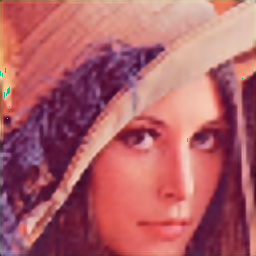

In [27]:
tensor_to_image = transforms.ToPILImage()
img = input_transform(Image.open('01.jpg')).cuda()

srresnet.eval()
pred = srresnet(img.unsqueeze(0))
pred = pred.squeeze(0).to(torch.device('cpu'))
tensor_to_image(pred.detach())

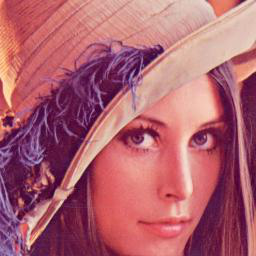

In [28]:
Image.open('01.jpg')

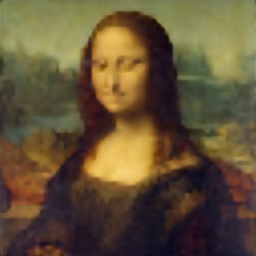

In [29]:
tensor_to_image = transforms.ToPILImage()
img = input_transform(Image.open('02.jpg')).cuda()

srresnet.eval()
pred = srresnet(img.unsqueeze(0))
pred = pred.squeeze(0).to(torch.device('cpu'))
tensor_to_image(pred.detach())

In [0]:
path = F"/content/drive/My Drive/Colab Notebooks/Deep Learning/Proj 2/srcnn_50epochs_l2_l1.pth" 
torch.save(srresnet.state_dict(), path)
